In [19]:
print("Jupyter is ready for CE40248")

Jupyter is ready for CE40248


Input -> Calculate forces and integrate equations of motion -> perform P, control T if necessary -> t = t + deltT -> Calculate and update the molecule position (-> t<tmax back to the calcualte forces tab) -> Output: key output is a trajectory file with positions at a given time, here the thermodynamics and transport properties are determined....

Sigma is the diameter of atom and epsilon is the energy of the particle

In order to control reaction in terms of energy, need to completely isolate the system. This is not physically 100% possible. Come with a theoretical limit. 

If try to determine a parameter, do not use the equilibration zone



CE40248 Coursework: Molecular Dynamics
Author: Alex Pooley
Date edited: 27/10/2025
Description: Code takes a series of parameters within a system and using the Lennard-Jones potential, calculates force and velocity to create a file of positions in space, for each molecule for each time step.

In [27]:
import numpy as np
# Functions used to determine the potential energies and the forces due to LJ and electrostatic effects

def U_LJ(r, sigma, epsilon): 
    # Function to calculate potential energy, using LJ potential.
    U = 4 * epsilon * ((sigma/r)**12 - (sigma/r)**6) # Dimensional U equation
    return U

def F_LJ(r, sigma, epsilon): 
    # Function to calculate force magnitude, using LJ potential.
    F = 24 * epsilon *(2*(sigma/r)**12 - (sigma/r)**6) / r # Dimensional F equation
    return F        
    
def U_electro(r, charges, i, j):    
    U = (charges[i] * charges[j] / (4 * np.pi * epsilon0 * r))
    return U

def F_electro(r, charges, rij, i, j):
    F = (charges[i] * charges[j] / (4 * np.pi * epsilon0 * r**3)) * rij # Calculate the force due to electrostatic interation
    return F 


In [38]:
# Initial Variables:
# =================================================
# MC Variables
nsteps = 1000            # Number of integration steps, where dt=0.005tau and tau = sigma*sqrt(mass/epsilon)
dimensionless_dt = 0.005  # Dimensionless time step

# Physcial Constants
epsilon0 = 8.854187817e-12  # Vaccum permivitty [F/m] [REF]
amu_to_kg = 1.6605e-27 # Conversion factor
kB = 1.380649e-23  # Boltzman Constant [J/K]

# Material Variables - Aargon
# sigma = 3.405 * 10**-10   # Distance at which U is zero [REF]
# epsilon = 1.65 * 10**-21  # Depth of potential well [REF]
# mass_atom = 6.63e-26      # Mass of one Aargon atom [kg] [REF]

# LJ parameters (nm and kJ/mol)
sigma_dict = {"H": 0.1*1e-9, "O": 0.315*1e-9, "C": 0.375*1e-9}                                  # [nm -> m] [REF]
epsilon_dict = {"H": (0.0*1000/6.022e23), "O": (0.65*1000/6.022e23), "C": (0.35*1000/6.022e23)} # [kJ/mol -> J] [REF]

# Water variables
water_N = 2
water_atoms = ["O", "H", "H"]               # Bond labels 
water_bonds = [(0,1), (0,2)]                # Bonds O-H twice
water_angles = [(1,0,2)]                    # Angles between H(1)-O(0)-H(2)
water_charges = [-0.834, 0.417, 0.417]      # Partial charges for TIP3P [REF]
water_bondlengths = [0.09572, 0.09572]      # Bond lengths [nm] [REF]
water_bondangles = [104.52]                 # Angles [degrees] [REF]

# Propylene Oxide variables 
po_N = 2
po_atoms = ["C", "C", "C", "O", "H", "H", "H", "H", "H", "H"]
po_bonds = [(0,1),(1,2),(2,3),(0,4),(0,5),(1,6),(1,7),(2,8),(2,9)]
po_charges = [0,0,0,-0.5,0.1,0.1,0.1,0.1,0.1,0.1]  # placeholders

# Masses
mass_element = {"H": 1, "O": 16, "C": 12} # [amu]
atom_types = water_atoms * water_N + po_atoms * po_N
mass  = np.array([mass_element[a]*amu_to_kg for a in atom_types])
N = len(atom_types)   # Number of particles

# Initial Calculations
charges = np.array(water_charges * water_N + po_charges * po_N) * 1.60218e-19  # convert e → C
dt = 0.5e-15               # Dimensional time step [s], 0.5 fs
sigma_ref = sigma_dict["O"]       # m
epsilon_ref = epsilon_dict["O"]   # J
tau = sigma_ref * np.sqrt(amu_to_kg / epsilon_ref)
dt = dimensionless_dt * tau
L = 5.0 * sigma_ref                            # Box length [m]
rc = 2.5 * sigma_ref # Reduced cutoff (no tail corrections), take as theres no interactions when th distance between the particles is this long

# Set random positions within the box 
np.random.seed(1) # Sets a random seed up
# positions = np.random.rand(N, 3) * L # Random initial positions, and then scaled by L to fit in the box (10 x 3 matrix)

# Set templates for each molecule within space:
# Using templates keep the molecules intact
# Water template (simplified linear for now)
water_template = np.array([[0.0, 0.0, 0.0], [0.095, 0.0, 0.0], [-0.095, 0.0, 0.0]])
# Propylene oxide template (simplified linear for now)
po_template = np.array([[0,0,0],[0.15,0,0],[0.3,0,0],[0.45,0,0],
                        [0,0.1,0],[0,-0.1,0],[0.15,0.1,0],[0.15,-0.1,0],
                        [0.3,0.1,0],[0.3,-0.1,0]])



In [39]:
# Set initial positions for each molecule
def place_molecule(template_coords, L):
    # Function to initialise coordinates for each atom within each molecule
    coords = template_coords.copy()      # Avoid modifying template, copys and tarnslates depending on the random nums. Ensures all atoms stay together
    translation = np.random.rand(3) * L  # Random translation vector [x, y, z] and scales to the box
    coords += translation                # Move molecule into random box location
    return coords

# Place molecules within space:
positions = [] # Initialise the position list

# Each call to the function returns a (n atoms per mol, 3) array, append collects them all and vstack
# forms (total atoms, 3) array
# Water:
for i in range(water_N):
    # For every molecule of water, place the molecule within the box 
    water_coords = place_molecule(water_template, L)
    positions.append(water_coords)

# PO:
for j in range(po_N):
    # For every molecule of po, place the molecule within the box 
    po_coords = place_molecule(po_template, L)
    positions.append(po_coords)

positions = np.vstack(positions) # Stacks both positions vertically


In [40]:
# Set intial velocities using Maxwell-Boltzman energy distribution (normal assumed)
T = 298 # Simulation temperature
std = np.sqrt(kB * T / mass[:, None])                     # Sets standard deviation for velocity initialisation, for mass, ensure correct atoms used
velocities = np.random.normal(0, 1, (len(mass), 3)) * std # Calculates intial velocity, with midpoint of zero
velocities -= velocities.mean(axis=0)                     # Removes energy drift and sets momentum to zero

In [41]:
def compute_forces(positions, atom_types, charges, rc): 
    # Function to determine the forces acting on each moleucle due to each 
    # interaction, if within distance applicable to LJ.
    
    N = len(positions)                # Gets number of particles from the positions array
    forces = np.zeros_like(positions) # Makes a matrix the same size as positions for forces in each direction
    potential = 0.0                   # Set the potential energy to zero

    # Following loop takes into account every interaction possible. i and j represent a different particle every loop
    for i in range(N - 1): # One less that the total number of particles (as each particle cannot interact with itself)
        
        for j in range(i + 1, N): # For particle i, work interaction to every other particle
            rij = positions[i] - positions[j] # Distance between the compared particles (vector)
            r = np.linalg.norm(rij)           # Finds the magnitude of the distance (Euclidian distance)
    
            if r < 1e-12: # Skip self/near-zero distances to avoid division by zero
                continue
            
            if r < rc: # If below the cut of radius, the molecules will interact
                # Get LJ parameters per atom type, using the Lorentz-Berthelot mixing rule
                sigma = 0.5 * (sigma_dict[atom_types[i]] + sigma_dict[atom_types[j]])
                epsilon = np.sqrt(epsilon_dict[atom_types[i]] * epsilon_dict[atom_types[j]])

                # Van der Walls interaction
                fij_mag = F_LJ(r, sigma, epsilon)   # Calls LJ force function (magnitude)
                fij_vec = fij_mag * (rij / r)       # Takes the magnitude of the forces and applies to all directions
                U_LJ_val = U_LJ(r, sigma, epsilon)  # Calls LJ potential energy function and adds

                # Electrostatic interation
                fC_vec = F_electro(r, charges, rij, i, j) # Calculate the force due to electrostatic interation
                U_C_val = U_electro(r, charges, i, j)     # Calculate the potential energy due to electrostatic interation
                print(U_C_val)
                # Add forces to each atom (Newton's 3rd law)
                forces[i] += fij_vec + fC_vec # Adds the force vector to atom i
                forces[j] -= fij_vec + fC_vec # Subtracts the force vector from j as moves in opposite direction

                # Add potential energy
                potential += U_LJ_val + U_C_val # Combines potenial energy due to LJ and charge
                   
    return forces, potential # Contains xyz forces for all particles and summed potential energy


In [42]:
import matplotlib.pyplot as plt

forces, pot = compute_forces(positions, atom_types, charges, rc) # Initialise the forces and U before alogrithm

KE, PE, TE = [], [], [] # Lists to store energies
save_stride = 10        # Only saves every 10th frame to reduce file size
traj = []               # list of snapshots for XYZ export

for step in range(nsteps): # Will run for number of step initialised earlier
    
    # Velocity-Verlet algorithm 
    velocities += 0.5 * (forces/mass[:, None]) * dt                  # Originally the random value, F = ma rearrangement
    positions += velocities * dt                                     # Then update positions accordingly due to timestep
    forces, pot = compute_forces(positions, atom_types, charges, rc) # Call the forces function, now with new positions
    velocities += 0.5 * (forces/mass[:, None]) * dt                  # As above...
   
    kin = 0.5 * np.sum(mass[:, None] * velocities**2) # From basic kinetic equation, take into account all particles
    KE.append(kin); PE.append(pot); TE.append(kin + pot)     # Add on the newly calculates parameters
    
    if step % save_stride == 0:       # If step is a multiple of the save_stride (10)
        traj.append(positions.copy()) # Only saves if mulitple of 10

-0.0
0.0
0.0
0.0
7.936199373396494e-20
3.1744798274585007e-21
3.1744798274585007e-21
3.1744798405603276e-21
3.1744798405603276e-21
3.174479747930848e-21
3.174479747930848e-21
-0.0
0.0
0.0
0.0
7.92666077034802e-20
3.183998894591703e-21
3.175367108867692e-21
3.1788064704243386e-21
3.1860572044151403e-21
3.16827338949498e-21
3.1696798351979112e-21
-0.0
0.0
0.0
0.0
7.916758114052497e-20
3.1931438180124353e-21
3.1760741789804182e-21
3.1829346029867465e-21
3.1975769974740865e-21
3.161900616033658e-21
3.164760511833156e-21
-0.0
0.0
0.0
0.0
7.906494497917286e-20
3.2019041659957983e-21
3.1766007124912353e-21
3.186861669235184e-21
3.2090356289175586e-21
3.155364648989425e-21
3.1597234344523976e-21
-0.0
0.0
0.0
0.0
7.89587403888465e-20
3.210269792556302e-21
3.1769464513388144e-21
3.1905855440533633e-21
3.220429845825742e-21
3.1486685703675595e-21
3.1545702609148935e-21
-0.0
0.0
0.0
0.0
7.884900947721577e-20
3.2182308537604657e-21
3.177111224331225e-21
3.1941042060983695e-21
3.2317559462059588e-21

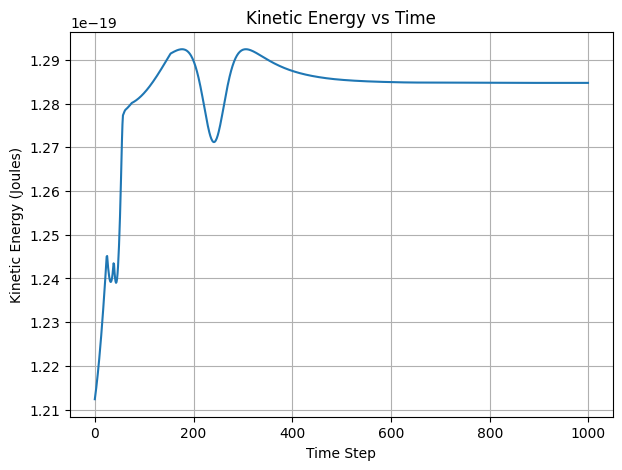

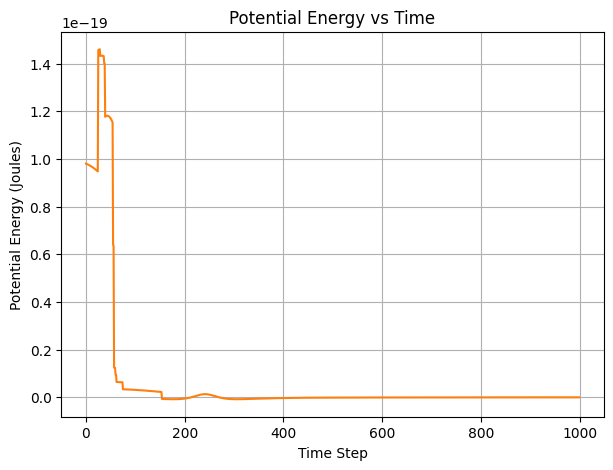

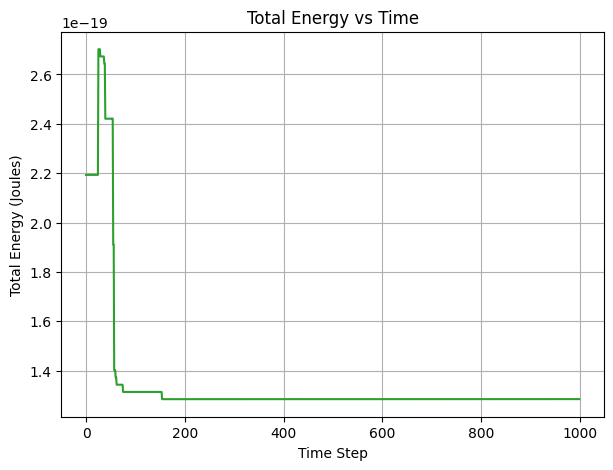

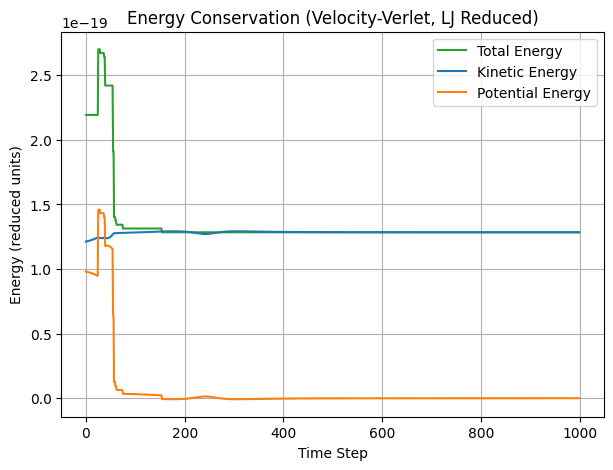

In [43]:
# Plotting energies:
# =============================================
# ---- Plot 1: Kinetic Energy ----
plt.figure(figsize=(7, 5))
plt.plot(KE, color='tab:blue')
plt.xlabel('Time Step')
plt.ylabel('Kinetic Energy (Joules)')
plt.title('Kinetic Energy vs Time')
plt.grid(True)
plt.show()

# ---- Plot 2: Potential Energy ----
plt.figure(figsize=(7, 5))
plt.plot(PE, color='tab:orange')
plt.xlabel('Time Step')
plt.ylabel('Potential Energy (Joules)')
plt.title('Potential Energy vs Time')
plt.grid(True)
plt.show()

# ---- Plot 3: Total Energy ----
plt.figure(figsize=(7, 5))
plt.plot(TE, color='tab:green')
plt.xlabel('Time Step')
plt.ylabel('Total Energy (Joules)')
plt.title('Total Energy vs Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(TE, label='Total Energy', color='tab:green')
plt.plot(KE, label='Kinetic Energy', color='tab:blue')
plt.plot(PE, label='Potential Energy', color='tab:orange')
plt.xlabel('Time Step')
plt.ylabel('Energy (reduced units)')
plt.title('Energy Conservation (Velocity-Verlet, LJ Reduced)')
plt.legend()
plt.grid(True)
plt.show()

In [32]:
scale_factor = 1e10  # meters → angstroms

with open("traj.xyz", "w") as f: # Open the traj file for writing 
    
    for k, frame in enumerate(traj):                      # Loops over every frame in traj
        step = k * save_stride                            # Recover original simulation step
        f.write(f"{N}\nStep {step} (scaled positions)\n") # Writes xyz header N and step number
        
        for x, y, z in frame: # Loop over every particle in the frame, x is first colum etc...
            x_s, y_s, z_s = x*scale_factor, y*scale_factor, z*scale_factor # Scale down to angstroms
            f.write(f"Ar {x_s:.6f} {y_s:.6f} {z_s:.6f}\n")                 # Writes to the file with the 


===============================================================================
Code below is an in text visualiser, not to be included within the coursework.

In [33]:
# ============================================
# Visualise Particle Dispersion from XYZ file
# using py3Dmol in Jupyter Notebook
# ============================================

# Step 1: Install py3Dmol if needed
!pip install py3Dmol

# Step 2: Import and load your .xyz file
import py3Dmol

# Replace this with your file name
filename = "traj.xyz"

with open(filename) as f:
    xyz_data = f.read()

# Step 3: Create viewer
view = py3Dmol.view(width=700, height=500)

# Add all XYZ frames as animation frames
view.addModelsAsFrames(xyz_data, 'xyz')

# Step 4: Style options
view.setStyle({'sphere': {'scale': 0.5, 'colorscheme': 'Jmol'}})  # spheres for particles
view.setBackgroundColor('white')
view.zoomTo()

# Step 5: Animation controls
# Adjust 'step' for speed; smaller = slower animation
view.animate({'loop': 'forward', 'reps': 0, 'step': 1})

# Step 6: Optional — draw a box to represent the simulation boundary
# If your XYZ doesn’t specify box dimensions, set them manually:
box_size = 10.0  # edit this to match your system dimensions

# Draw edges of a cubic box for context
edges = [
    [[0,0,0],[box_size,0,0]], [[0,0,0],[0,box_size,0]], [[0,0,0],[0,0,box_size]],
    [[box_size,box_size,0],[box_size,0,0]], [[box_size,box_size,0],[0,box_size,0]],
    [[box_size,0,box_size],[box_size,0,0]], [[box_size,0,box_size],[0,0,box_size]],
    [[0,box_size,box_size],[0,box_size,0]], [[0,box_size,box_size],[0,0,box_size]],
    [[box_size,box_size,box_size],[box_size,box_size,0]],
    [[box_size,box_size,box_size],[box_size,0,box_size]],
    [[box_size,box_size,box_size],[0,box_size,box_size]]
]

for edge in edges:
    view.addLine({'start': {'x': edge[0][0], 'y': edge[0][1], 'z': edge[0][2]},
                  'end': {'x': edge[1][0], 'y': edge[1][1], 'z': edge[1][2]},
                  'color': 'black', 'radius': 0.05})

view.show()


Defaulting to user installation because normal site-packages is not writeable


3Dmol.js failed to load for some reason. Please check your browser console for error messages.